<a href="https://colab.research.google.com/github/lskenkf/Binance/blob/main/bolt_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# https://app2.greenhouse.io/tests/e3ddd71c22e3612ce68124015f5d6fc2?utm_medium=email&utm_source=TakeHomeTest

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
import numpy as np

In [5]:
data_path = '/content/drive/MyDrive/tasks/bolt/data.csv'
data_df = pd.read_csv(data_path)

In [6]:
# Business Problem: What is the drive value of each area (if there is any) for the next hour.
# Algo Problem: Given historical data can we built a model to predict given area's drive value in the future
# Area Definition: we generate a mesh to get the partition of the whole map and compute the drive value on a hourly basis. 

In [7]:
# ML task: predict the areas' drive value depending on time (week day and hours) 
# split date time into: week day and hours

data_df['start_time'] = pd.to_datetime(data_df['start_time'])
data_df['hour'] = data_df['start_time'].dt.hour
data_df['weekday'] = data_df['start_time'].dt.weekday
data_df['date'] = data_df['start_time'].dt.date

data_df['distance'] = ((data_df['start_lat'] - data_df['end_lat'])**2 +   (data_df['start_lng'] - data_df['end_lng'])**2)**(1/2)

# We compute the area so that we can further predict the future drive value in each of them.
bins = 150
labels = [str(el) for el in list(range(bins))]
data_df['start_lat_bin'] = pd.cut(data_df['start_lat'], bins,labels)
data_df['start_lng_bin'] = pd.cut(data_df['start_lng'], bins,labels)

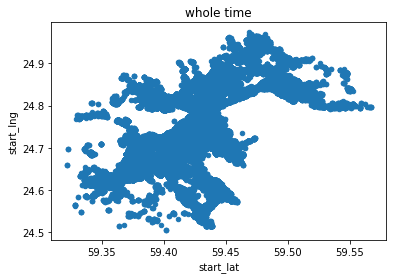

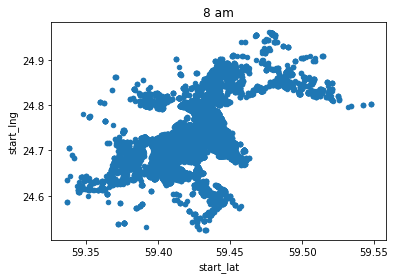

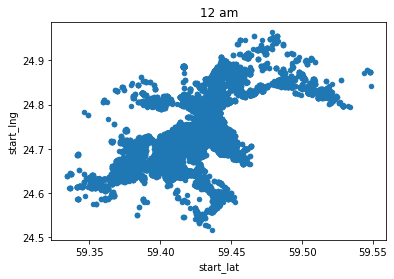

In [8]:
# The distribution of start location is quite consistent giving the below graphs.
data_df.plot.scatter(x='start_lat', y='start_lng',title='whole time')
data_df[data_df.hour == 8].plot.scatter(x='start_lat', y='start_lng',title='8 am')
data_df[data_df.hour == 17].plot.scatter(x='start_lat', y='start_lng', title ='12 am')

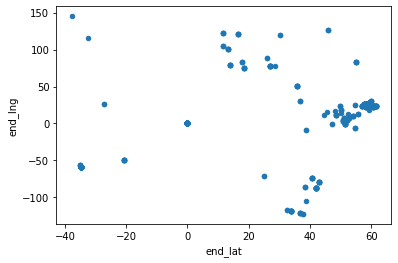

In [9]:
# We have much fewer destination point comparing with start points.
data_df.plot.scatter(x='end_lat', y='end_lng')

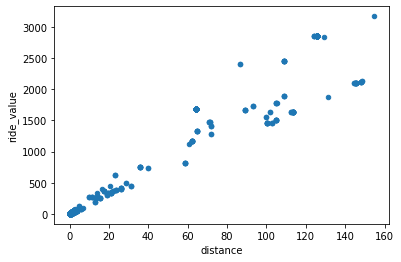

In [10]:
# The longer the distance the bigger the ride value.
data_df.plot.scatter(x='distance',y='ride_value')

In [11]:
# train test split: we use a split point to get the train and test partition. Afterwards, we will get the drive value for each area given the weekday and hour.
# and apply the computed drive values to the test set.
date_list = data_df.date.value_counts().reset_index().sort_values(by='index').reset_index(drop=True)
display(date_list.head())

,index,date
0,2022-03-01,19532
1,2022-03-02,20436
2,2022-03-03,18494
3,2022-03-04,20695
4,2022-03-05,23000


In [12]:
# we will start the split point from 09-03-2022 since the first week has no monday.
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

cols = ['start_lat_bin','start_lng_bin','weekday','hour']


def get_eval_result(split_date):
    true_pred = get_true_pred(split_date)
    pred = true_pred.pred_total_ride_value.values
    true = true_pred.true_total_ride_value.values
    rmse = mean_squared_error(y_true=true, y_pred=pred, squared = False)
    pr = pearsonr(pred, true)[0]
    r2score = r2_score(pred, true)
    eval_result = [rmse, pr, r2score]
    return eval_result

def get_true_pred(split_date):
    #split_date = datetime.strptime(split_date, '%Y-%m-%d').date()
    train = data_df[data_df.date<=split_date]
    test  = data_df[data_df.date>split_date]

    pred_drive_value = get_pred_drive_value(train)
    true_drive_value = get_true_drive_value(test)

    true_pred = true_drive_value.merge(
        pred_drive_value, 
        how='left', 
        on=cols)
    
    return true_pred

def get_pred_drive_value(train):
    pred_drive_value = train.groupby(cols).agg(pred_total_ride_value = ('ride_value','sum')).reset_index()
    return pred_drive_value

def get_true_drive_value(test):
    true_drive_value = test.groupby(cols).agg(true_total_ride_value = ('ride_value','sum')).reset_index()
    return true_drive_value


In [13]:
start_date = datetime.strptime('2022-03-09', '%Y-%m-%d').date()
date_index = date_list['index'].values
date_indexs = [el for el in date_index if el >=start_date]
results = []
# uncomment if you want to try it yourself.
#for date_index in date_indexs:
#    try:
#        results.append(get_eval_result(date_index))
#    except:
#        pass

In [14]:
results = [
    [19.119432508839243, 0.1448876569978398, -2.3426830455315253],
    [18.442707665116572, 0.17640229511445016, -1.7391501010023314],
    [17.864987557059298, 0.2045786107589088, -1.3961182384827118],
    [17.807403673803233, 0.20388200863378383, -1.1940098958907504],
    [17.549885275812866, 0.21607551864989022, -1.0441287208388168],
    [17.650814520237365, 0.20838689621772466, -0.9430248589877901],
    [18.12480223561602, 0.1794459290000495, -0.6792397841127522],
    [18.077755154720013, 0.18247083233915617, -0.5177837493632256],
    [18.28043343895473, 0.17451609165787912, -0.3856282497458825],
    [18.266052657663156, 0.180004387752462, -0.2770679334171835],
    [18.294918242130997, 0.18359095631928785, -0.20879174042380177],
    [18.38079246217479, 0.1868573647793988, -0.14202345318846676],
    [18.244092543266614, 0.1986238595645275, -0.10960325238422652],
    [17.47808132731095, 0.21504738872415005, -0.10729206412384285],
    [17.26463366127921, 0.23758003669242242, -0.0983282018039735],
    [16.634616226095105, 0.24822471272350657, -0.09396634420417227],
    [16.660366169242184, 0.200801865059276, -0.1478710522795199],
    [15.742601423582295, 0.20777354682107005, -0.2658430985899676],
    [13.568847697604363, 0.2847183018195858, -0.13990144863831722]
    ]


In [15]:
plot_df = pd.DataFrame(results,columns = ['rmse','person_correlation','r2_score'])
plot_df = plot_df.reset_index()
plot_df.head()

,index,rmse,person_correlation,r2_score
0,0,19.119433,0.144888,-2.342683
1,1,18.442708,0.176402,-1.739150
2,2,17.864988,0.204579,-1.396118
3,3,17.807404,0.203882,-1.194010
4,4,17.549885,0.216076,-1.044129


In [16]:
# As we will see as we use more data, the performance of the model is getting better.

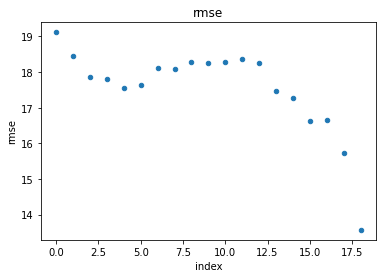

In [17]:
# As we use more data, the average error of the model is reducing
plot_df.plot.scatter(x='index', y ='rmse', title='rmse')

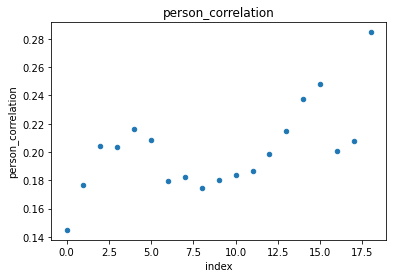

In [18]:
# As we use more data, the correlation between the pred and true is increasing.

plot_df.plot.scatter(x='index', y ='person_correlation', title= 'person_correlation')

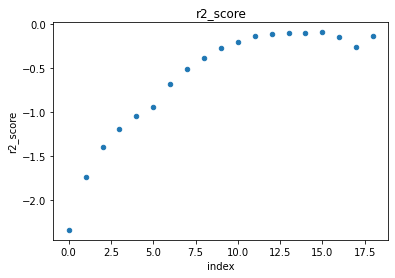

In [19]:
# As we use more data, the predicted value is still very poorly on explain the true value/drive value.
plot_df.plot.scatter(x='index', y ='r2_score', title= 'r2_score')

In [20]:
# As we use more advanced model such like FFN and adding more features and preprocessing process, such like scaling I think we will boost the performance of models to this problem.

In [21]:
# deployment: When we have the trained model, for each driver depending on their location we can recommend to them the next top-n areas ranking by drive value, therefore they 
# can choose whether to drive to one of these locations.

# A/B test:
# At each hour we take two groups with same size, group A will drive freely and group B will get our recommendation. Then in the next hours we will measure their total aggregated 
# drive value i.e., how much money they have made with and without our recommendation. We will observe this metrics for a certain period of time so that we can decide whether this 
# new feature actually can bring positive impact on the business.